<h1><center>Implementing a Regression Tree</center></h1>

In this implementation, Boston house prices dataset is used. You can find more detail on the dataset [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset). 

In [1]:
import numpy as np
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
boston = load_boston()
data = np.column_stack([boston['data'], boston['target']])
np.random.seed(1)
np.random.shuffle(data)
X, y = data[:,:-1], data[:,-1]
X_train, y_train = X[:400], y[:400]
X_test, y_test = X[400:], y[400:]
y_train = y_train.reshape(400,1)
train_data = np.hstack((X_train,y_train))

Correlations between features and house prices is visualized using a heatmap.

In [3]:
#Create the correlation coefficient matrix
co_co = np.corrcoef(train_data, rowvar=False)
#It is a 14x14 matrix (features+label)
co_co.shape

(14, 14)

Correlation Coefficient Matrix


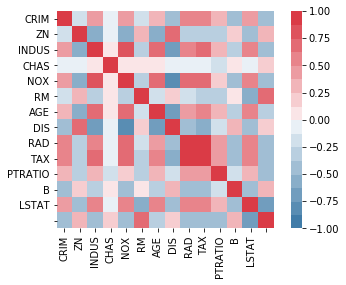

In [4]:
#Visualize the correlation coefficient matrix as a heatmap
heat_map = sns.heatmap(co_co, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(240, 10, n=16),square=True)

features = boston['feature_names']

heat_map.set_xticklabels(
    features,
    rotation=90
)

heat_map.set_yticklabels(
    features,
    rotation=0
)
print("Correlation Coefficient Matrix")

According to above heatmap:
<ul>
Strong correlations:
<li> House price (MEDV) & % lower status of the population (LSTAT)</li>
<li> House price (MEDV) & average number of rooms per dwelling (RM)</li>
<li> Proportion of non-retail business acres per town (INDUS) & nitric oxides concentration(NOX)</li>
<li> Full-value property-tax rate (TAX) & index of accessibility to radial highways (RAD)</li>
<li> Weighted distances to five Boston employment centres (DIS) & nitric oxides concentration (NOX)</li>
</ul>

## Implementation

The splitting criteria (Residual Sum of Squares) which is used to decide the most discriminative features at each step is implemented. RSS is computed as follow: 

$$RSS =\sum_{\text {left }}\left(y_{i}-y_{L}^{*}\right)^{2}+\sum_{\text {right }}\left(y_{i}-y_{R}^{*}\right)^{2}$$

where $y_L^* and y_L^*$ are mean y-value of left and right nodes.

The most correlated and least correlated features with the output prices are selected according to correlation coefficient matrix, which are LSTAT and DIS, respectively. For both features, $RSS$ is computed for every possible split threshold and thresholds versus $RSS$ scores are plotted.

C:\Users\suuser\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\suuser\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


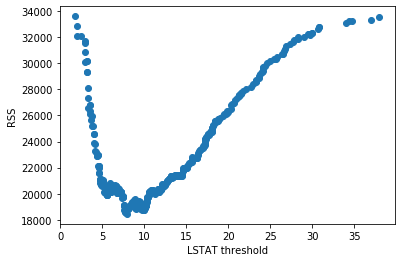

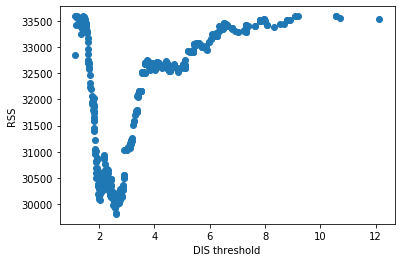

In [5]:
def compute_RSS(left_region, right_region): 
    left = np.sum((left_region-np.mean(left_region))**2)
    right = np.sum((right_region-np.mean(right_region))**2)
    return left + right

def plot_threshold_vs_RSS(feature, y, x_label):
    RSS = []
    for i, threshold in enumerate(feature):
        y_split = feature < threshold
        RSS.append(compute_RSS(y[y_split], y[~y_split]))
    plt.scatter(feature,RSS)
    plt.xlabel(x_label)
    plt.ylabel("RSS")
    plt.show()  
        
    
#Most correlated = LSTAT
plot_threshold_vs_RSS(X_train[:,12], y_train, "LSTAT threshold")

#least correlated = DIS
plot_threshold_vs_RSS(X_train[:,7], y_train,"DIS threshold")


The features display similar characteristics. As the threshold value increases, residual sum of squares first decreases, then 
increases.

The training procedure of a regression tree using $RSS$ as split criteria is implemented. Rule tree is built recursively by traversing all features and considering each split threshold to find the optimum split, at every node. Maximum depth is used as the stopping condition. A procedure to predict test features is written. This procedure follows the rules learned during the training to arrive at a leaf and predicts the output as the mean output of the arrived leaf samples. 


In [6]:
class RegressionTree(object):
    def __init__(self, max_depth):
        self.max_depth = max_depth
    
    def model(self, X_train, y_train, depth=0):
        if depth == self.max_depth or len(X_train) < 2:
            return {'prediction': np.round(np.mean(y_train))}
        
        col_index, threshold  = self.find_best_split(X_train, y_train)
        split = X_train[:, col_index] < threshold
        tree = {'column': features[col_index],'column_index':col_index,'threshold':threshold}
        tree['left'] = self.model(X_train[split], y_train[split], depth+1)
        tree['right'] = self.model(X_train[~split], y_train[~split], depth+1)
        self.trees = tree
        return tree
    
    def find_best_split(self, X_train, y_train):
        best_feature_index, best_threshold  = [0,0]
        min_RSS = np.inf
        for i, feature in enumerate(X_train.T): 
            possible_thresholds = np.unique(feature).tolist()
            possible_thresholds.sort()
            possible_thresholds = possible_thresholds[1:]
            for value in possible_thresholds:
                split = feature < value
                RSS = compute_RSS(y_train[split],y_train[~split])
                if RSS < min_RSS:
                    min_RSS = RSS
                    best_threshold = value
                    best_feature_index  = i
        return best_feature_index, best_threshold   
    
    def predict(self, observation):
        prediction = None
        tree = self.trees
        while prediction is None:
            feature = tree['column_index']
            threshold = tree['threshold']
            if observation[feature] < threshold:  
                tree = tree['left']
            else:
                tree = tree['right']
            prediction = tree.get('prediction', None)
        return prediction
    

Decision tree with the terminating condition max_depth = 3 is created and visualized both using pprint and Smartdraw. 

In [8]:
import pprint
reg_tree = RegressionTree(max_depth=3)
r = reg_tree.model(X_train, y_train)

pprint.pprint(r)

{'column': 'LSTAT',
 'column_index': 12,
 'left': {'column': 'RM',
          'column_index': 5,
          'left': {'column': 'DIS',
                   'column_index': 7,
                   'left': {'prediction': 50.0},
                   'right': {'prediction': 28.0},
                   'threshold': 1.6132},
          'right': {'column': 'CRIM',
                    'column_index': 0,
                    'left': {'prediction': 46.0},
                    'right': {'prediction': 22.0},
                    'threshold': 3.47428},
          'threshold': 7.454},
 'right': {'column': 'LSTAT',
           'column_index': 12,
           'left': {'column': 'DIS',
                    'column_index': 7,
                    'left': {'prediction': 50.0},
                    'right': {'prediction': 21.0},
                    'threshold': 1.2852},
           'right': {'column': 'NOX',
                     'column_index': 4,
                     'left': {'prediction': 17.0},
                     'right':

![dd.PNG](dd.PNG)

8 trees are created with different depth values, using the training data. Predictions are made both using the test and train data, and their $R^2$ scores are compared. 

In [9]:
def calculate_r2_score(X, y, reg_tree):
    y_pred = []
    for i in range(0,len(X)):
        sample_pred = reg_tree.predict(X[i,:])
        y_pred.append(sample_pred)
    return r2_score(y, y_pred)

In [10]:
for max_depth in range(3,11):
    reg_tree = RegressionTree(max_depth=max_depth)
    reg_tree.model(X_train, y_train)
    
    r2_score_train = calculate_r2_score(X_train, y_train, reg_tree)
    r2_score_test = calculate_r2_score(X_test, y_test, reg_tree)

    print(f"When max depth is : {max_depth}, training R2 is: {r2_score_train}, test R2 is: {r2_score_test}")

When max depth is : 3, training R2 is: 0.8128332401687309, test R2 is: 0.7662722488374899
When max depth is : 4, training R2 is: 0.8779839085768095, test R2 is: 0.8817606348892848
When max depth is : 5, training R2 is: 0.9164657921375308, test R2 is: 0.8460770087576039
When max depth is : 6, training R2 is: 0.9411399257404441, test R2 is: 0.8556570955762078
When max depth is : 7, training R2 is: 0.9576449205153659, test R2 is: 0.8676981221280313
When max depth is : 8, training R2 is: 0.971029923493008, test R2 is: 0.8490433200431808
When max depth is : 9, training R2 is: 0.9791276121271688, test R2 is: 0.8486038665193917
When max depth is : 10, training R2 is: 0.9842482093517115, test R2 is: 0.8442532766338788
